In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os
import glob
from h5_util import concatenate_files, load_h5
                
src_dir = 'data/RKOl'

def violin_plot(to_plot, title=None, xlabel=None, ylabel=None, labels=None, savefig=None):
    
    fig = plt.figure()

    # Create an axes instance
    ax = fig.add_axes([0,0,1,1])

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if labels is not None:
        set_axis_style(ax, labels)

    # Create the boxplot
    bp = ax.violinplot(to_plot, showmedians=True, showmeans=True)
    bp['cmeans'].set_color('white')
    bp['cmedians'].set_color('black')
    for pc in bp['bodies']:
        #pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)
    if savefig is not None:
        fig.savefig(savefig, format='pdf', bbox_inches="tight")
    plt.show()
    
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

In [ ]:
files = glob.glob(os.path.join(src_dir, '*.h5'))
dst = os.path.join(src_dir, 'info.h5')
concatenate_files(dst, files)

In [24]:
data = load_h5(os.path.join(src_dir, "info.h5"))

In [33]:
for key,value in data.items():
    print(key)
    for k,v in value.items():
        print(k,v.shape)

global
alleles (7020,)
chrom (7020,)
motif_len (7020,)
n_reads (7020,)
n_reads_corr (7020,)
n_umi (7020,)
n_umi_corr (7020,)
nucl (7020, 1)
pos (7020,)
umi
alleles (7325,)
avg_qual (7325,)
cfreq (7325,)
chrom (7325,)
count (7325,)
freq (7325,)
motif_len (7325,)
nucl (7325, 1)
pos (7325,)
qual (7325,)


### At umi level

In [45]:
data_umi = data['umi']

#### Frequency of selected indel

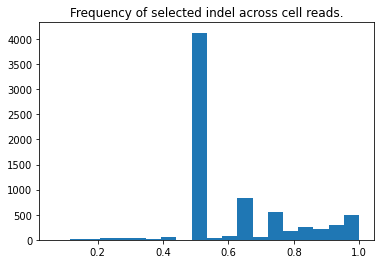

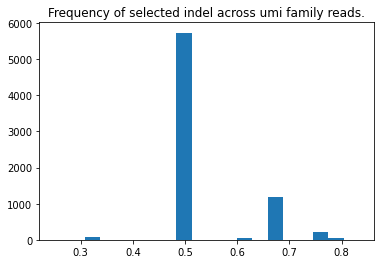

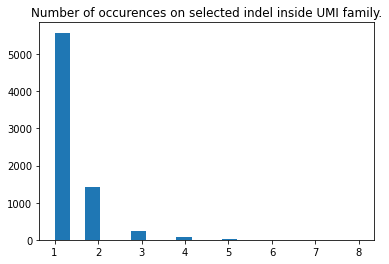

In [46]:
plt.hist(data_umi['cfreq'], bins=20)
plt.title('Frequency of selected indel across cell reads.')
plt.show()
plt.hist(data_umi['freq'], bins=20)
plt.title('Frequency of selected indel across umi family reads.')
plt.show()
plt.hist(data_umi['count'], bins=20)
plt.title('Number of occurences on selected indel inside UMI family.')
plt.show()

#### Selected indel base quality vs frequency

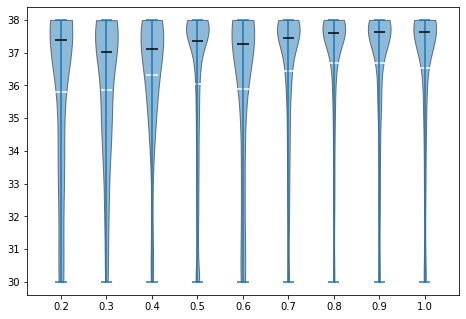

In [53]:
freq = np.round(data_umi['cfreq'], 1)
uni, counts = np.unique(freq, return_counts=True)
asort = np.argsort(counts)
i = next(i for i,x in enumerate(asort[-1::-1]) if counts[x]<30)
uni = sorted(uni[asort[-i:]])
to_plot = []
for f in uni:
    qf = data_umi['qual'][freq==f]
    qf = np.clip(qf, 30, 40)
    to_plot.append(qf)
violin_plot(
    to_plot,
    labels=tuple(uni)
)
plt.show()

### At (site, cell) level

#### Proportion of corrected reads & umis

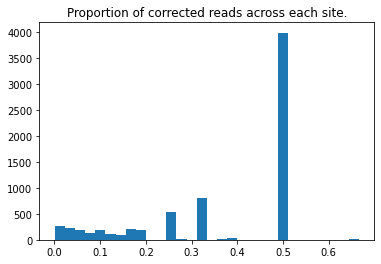

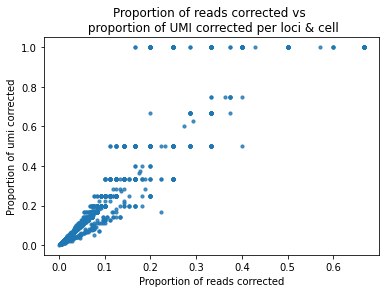

In [27]:
X = np.divide(data['global']['n_reads_corr'], data['global']['n_reads'])
Y = np.divide(data['global']['n_umi_corr'], data['global']['n_umi'])
plt.hist(X, bins=30)
plt.title('Proportion of corrected reads across each site.')
plt.show()
plt.scatter(X, Y, alpha=0.8, s=10)
plt.title('Proportion of reads corrected vs \n proportion of UMI corrected per loci & cell')
plt.xlabel('Proportion of reads corrected')
plt.ylabel('Proportion of umi corrected')
plt.show()

In [28]:
np.any(data['global']['n_reads_corr']==0)

False

In [26]:
np.unique(data['umi']['alleles'], return_counts=True)

(array([2, 3]), array([5387,   33]))

In [24]:
np.unique(
    [
        chr(int(x)) 
        for x,y in zip(data['umi']['nucl'], data['umi']['motif_len'])
        if x-int(x)>1/y
    ],
    return_counts=True
)

(array(['A', 'C', 'G', 'T'], dtype='<U1'), array([ 664, 1111, 1922, 1099]))

In [34]:
for k,v in data['umi'].items():
    u,c = np.unique(v, return_counts=True)
    if len(u)<30:
        print(k)
        print(list(zip(u,c)))

alleles
[(2, 7282), (3, 43)]
avg_qual
[(0.0, 7325)]
chrom
[(1, 633), (2, 343), (3, 280), (4, 470), (5, 232), (6, 245), (7, 498), (8, 595), (9, 329), (10, 180), (11, 487), (12, 398), (13, 201), (14, 177), (15, 119), (16, 218), (17, 567), (18, 48), (19, 340), (20, 302), (21, 67), (22, 406), (88, 190)]
count
[(1, 5576), (2, 1427), (3, 247), (4, 64), (5, 10), (8, 1)]
freq
[(0.25, 6), (0.3333333333333333, 80), (0.4, 4), (0.5, 5736), (0.6, 40), (0.6666666666666666, 1196), (0.7142857142857143, 3), (0.75, 206), (0.8, 47), (0.8333333333333334, 7)]
motif_len
[(2, 559), (3, 3021), (4, 801), (5, 1308), (6, 1099), (7, 537)]


In [65]:
n_reads = dict()
n_umis = dict()
info = data["global"]
for i in range(len(info["chrom"])):
    site = (info["chrom"][i], info["pos"][i])
    n_reads[site] = info["n_reads"][i]
    n_umis[site] = info["n_umi"][i]